# German Traffic Signs Classification

## Parameters

In [1]:
# Directories where training and testing datasets located
PATH = '/home/ivan/Documents/Study/Traffic signs/Kaggle/'
TESTING_PATH = '/home/ivan/Documents/Study/Traffic signs/GTSRB/Final_Test/Images'
# Minimal number of samples for each class for data augmentation 
MIN_IMGS_IN_CLASS = 500
# Learning parameters
EPOCHS = 100
INIT_LR = 0.001
BATCH_SIZE = 256
SET_DECAY = True

## Part I: Getting training data ready

### Imports

In [2]:
import random
import csv
import cv2 as cv
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

/home/ivan/Documents/Environments/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ivan/Documents/Environments/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ivan/Documents/Environments/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ivan/Documents/Environ

### Load data

At first, we need to load testing data from the directory it is stored

In [3]:
images = [] # images
labels = [] # corresponding labels

# loop over all 43 classes
gtFile = open(PATH + '/Train.csv') # annotations file
gtReader = csv.reader(gtFile, delimiter=',') # csv parser for annotations file
next(gtReader) # skip header
# loop over all images in current annotations file
for row in gtReader:
    img = cv.imread(PATH + '/' + row[7])
    images.append(cv.resize(img, (28, 28)))
    labels.append(row[6]) # the 6th column is the label
gtFile.close()

Check what we loaded

In [4]:
print('Number of loaded images: ' + str(len(images)))
print('Number of loaded labels: ' + str(len(labels)))

Number of loaded images: 39209
Number of loaded labels: 39209


### Prepare initial data

Let's convert arrays of labels and images to np arrays to simplify further manipulations

In [5]:
train_X = np.asarray(images)
train_X = train_X / 255
train_X = np.asarray(train_X, dtype = "float32")
train_Y = np.asarray(labels, dtype= "float32")

So, now we have an array of shape:

In [6]:
print('Shape of training array: ' + str(train_X.shape))

Shape of training array: (39209, 28, 28, 3)


### Data exploration

As a start of the data exploration, let's check how much classes we have and how much images in training set we have for each class

In [7]:
def count_images_in_classes(lbls):
    dct = {}
    for i in lbls:
        if i in dct:
            dct[i] += 1
        else:
            dct[i] = 1
    return dct

In [8]:
samples_distribution = count_images_in_classes(train_Y)
print(samples_distribution)

{20.0: 360, 0.0: 210, 1.0: 2220, 2.0: 2250, 3.0: 1410, 4.0: 1980, 5.0: 1860, 6.0: 420, 7.0: 1440, 8.0: 1410, 9.0: 1470, 10.0: 2010, 11.0: 1320, 12.0: 2100, 13.0: 2160, 14.0: 780, 15.0: 630, 16.0: 420, 17.0: 1110, 18.0: 1200, 19.0: 210, 21.0: 330, 22.0: 390, 23.0: 510, 24.0: 270, 25.0: 1500, 26.0: 600, 27.0: 240, 28.0: 540, 29.0: 270, 30.0: 450, 31.0: 780, 32.0: 240, 33.0: 689, 34.0: 420, 35.0: 1200, 36.0: 390, 37.0: 210, 38.0: 2070, 39.0: 300, 40.0: 360, 41.0: 240, 42.0: 240}


In [9]:
def distribution_diagram(dct):
    plt.bar(range(len(dct)), list(dct.values()), align='center')
    plt.xticks(range(len(dct)), list(dct.keys()), rotation=90, fontsize=7)
    plt.show()

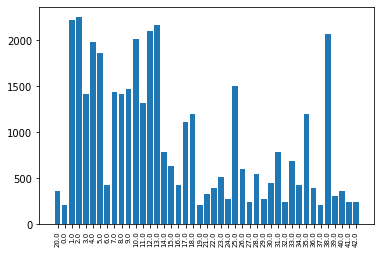

In [10]:
distribution_diagram(samples_distribution)

Plot one image from each class to better understand the data

In [11]:
def preview(images, labels):
    plt.figure(figsize=(16, 16))
    for c in range(len(np.unique(labels))):
        i = random.choice(np.where(labels == c)[0])
        plt.subplot(10, 10, c+1)
        plt.axis('off')
        plt.title('class: {}'.format(c))
        plt.imshow(images[i])

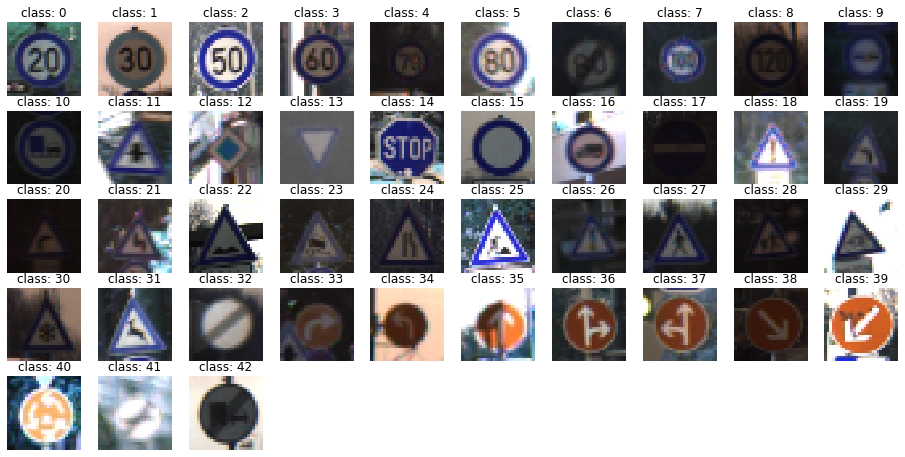

In [12]:
preview(train_X, train_Y)

### Data augmentation

Now, we can find that the training dataset is not well-balanced, but we can deal with this fact using data augmentation technique

In [13]:
def augment_imgs(imgs, p):
    """
    Performs a set of augmentations with with a probability p
    """
    from imgaug import augmenters as iaa
    augs =  iaa.SomeOf((2, 4),
          [
              iaa.Crop(px=(0, 4)), # crop images from each side by 0 to 4px (randomly chosen)
              iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
              iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
              iaa.Affine(rotate=(-45, 45)), # rotate by -45 to +45 degrees)
              iaa.Affine(shear=(-10, 10)) # shear by -10 to +10 degrees
          ])
    
    seq = iaa.Sequential([iaa.Sometimes(p, augs)])
    res = seq.augment_images(imgs)
    return res

In [14]:
def augmentation(imgs, lbls):
    classes = count_images_in_classes(lbls)
    for i in range(len(classes)):
        if (classes[i] < MIN_IMGS_IN_CLASS):
            # Number of samples to be added
            add_num = MIN_IMGS_IN_CLASS - classes[i]
            imgs_for_augm = []
            lbls_for_augm = []
            for j in range(add_num):
                im_index = random.choice(np.where(lbls == i)[0])
                imgs_for_augm.append(imgs[im_index])
                lbls_for_augm.append(lbls[im_index])
            augmented_class = augment_imgs(imgs_for_augm, 1)
            augmented_class_np = np.array(augmented_class)
            augmented_lbls_np = np.array(lbls_for_augm)
            imgs = np.concatenate((imgs, augmented_class_np), axis=0)
            lbls = np.concatenate((lbls, augmented_lbls_np), axis=0)
    return (imgs, lbls)

In [15]:
train_X, train_Y = augmentation(train_X, train_Y)

After augmentation our training dataset has the folowing shape:

In [16]:
print(train_X.shape)
print(train_Y.shape)

(42739, 28, 28, 3)
(42739,)


Let's check data distribution again

In [17]:
augmented_samples_distribution = count_images_in_classes(train_Y)
print(augmented_samples_distribution)

{20.0: 500, 0.0: 500, 1.0: 2220, 2.0: 2250, 3.0: 1410, 4.0: 1980, 5.0: 1860, 6.0: 500, 7.0: 1440, 8.0: 1410, 9.0: 1470, 10.0: 2010, 11.0: 1320, 12.0: 2100, 13.0: 2160, 14.0: 780, 15.0: 630, 16.0: 500, 17.0: 1110, 18.0: 1200, 19.0: 500, 21.0: 500, 22.0: 500, 23.0: 510, 24.0: 500, 25.0: 1500, 26.0: 600, 27.0: 500, 28.0: 540, 29.0: 500, 30.0: 500, 31.0: 780, 32.0: 500, 33.0: 689, 34.0: 500, 35.0: 1200, 36.0: 500, 37.0: 500, 38.0: 2070, 39.0: 500, 40.0: 500, 41.0: 500, 42.0: 500}


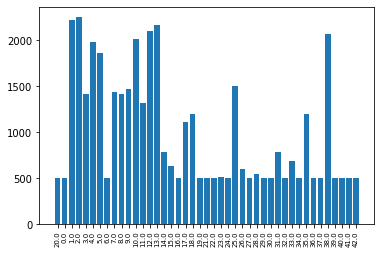

In [18]:
distribution_diagram(augmented_samples_distribution)

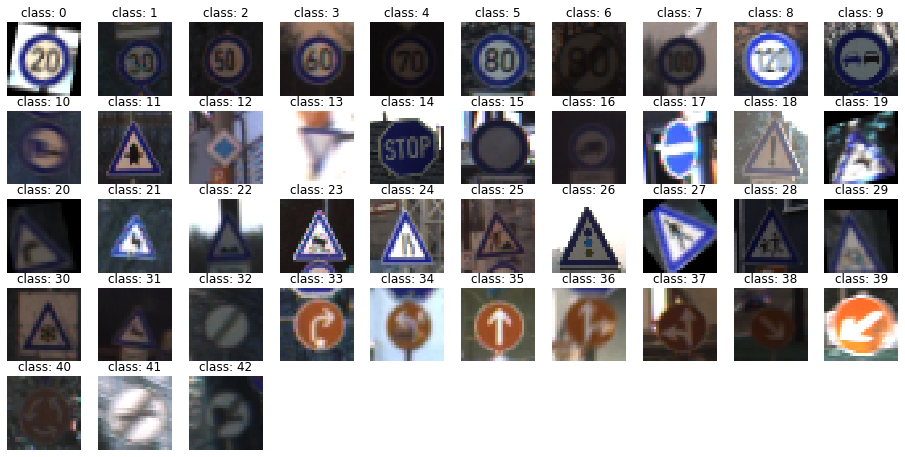

In [19]:
preview(train_X, train_Y)

### Image preprocessing

Grayscale all images in order to improve efficiency of our neural classifier

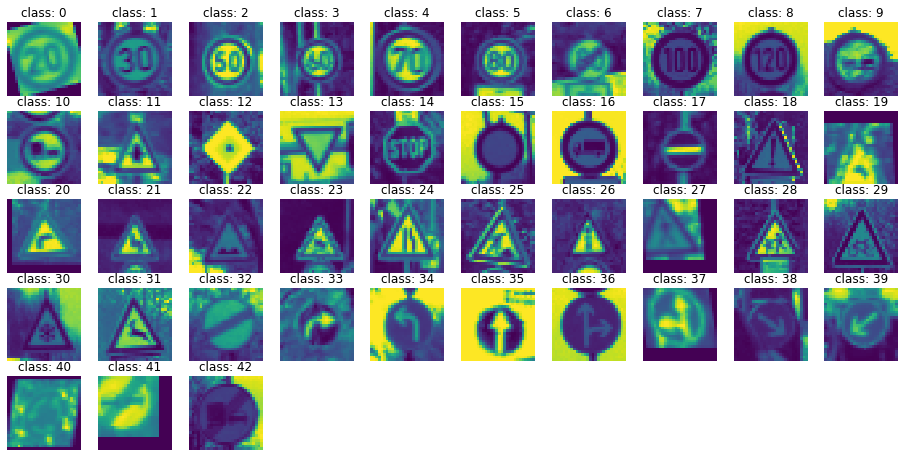

In [20]:
train_X = rgb2gray(train_X)
preview(train_X, train_Y)

## Part II: Neural network model development

In [21]:
def build(width, height, depth, classes):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = keras.Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # CONV => RELU => BN => POOL
    model.add(Conv2D(8, (5, 5), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # second set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [22]:
model = build(28, 28, 1, 43)

In [23]:
if SET_DECAY == True:
    opt = Adam(lr=INIT_LR, decay=INIT_LR / (EPOCHS * 0.5))
else:
    opt = Adam(lr=INIT_LR)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

## Part III: Test data loading and preparation

In [24]:
test_images = [] # images
test_labels = [] # corresponding labels

# loop over all 43 classes
gtFile = open(PATH + '/Test.csv') # annotations file
gtReader = csv.reader(gtFile, delimiter=',') # csv parser for annotations file
next(gtReader) # skip header
# loop over all images in current annotations file
for row in gtReader:
    #print(PATH + row[7])
    img = cv.imread(PATH + row[7])
    test_images.append(cv.resize(img, (28, 28)))
    test_labels.append(row[6]) # the 6th column is the label
gtFile.close()

In [25]:
test_X = np.asarray(test_images)
test_X = test_X / 255
test_X = np.asarray(test_X, dtype = "float32")

In [26]:
test_X = rgb2gray(test_X)
test_X.shape

(12630, 28, 28)

In [27]:
test_Y = np.asarray(test_labels, dtype = "float32")

In [28]:
print(train_X.shape)
train_X_ext = np.expand_dims(train_X, axis=3)
print(train_X_ext.shape)
print(train_Y.shape)
train_Y_ext = np.expand_dims(train_Y, axis=3)
print(train_Y_ext.shape)

(42739, 28, 28)
(42739, 28, 28, 1)
(42739,)
(42739, 1)


/home/ivan/Documents/Environments/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


## Part IV: Model training and testing

In [29]:
H = model.fit(train_X_ext, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 42739 samples
Epoch 1/100
42739/42739 [==============================] - 20s 477us/sample - loss: 3.4705 - accuracy: 0.1693
Epoch 2/100
42739/42739 [==============================] - 20s 459us/sample - loss: 1.8071 - accuracy: 0.4750
Epoch 3/100
42739/42739 [==============================] - 20s 470us/sample - loss: 1.1299 - accuracy: 0.6586
Epoch 4/100
42739/42739 [==============================] - 20s 471us/sample - loss: 0.7968 - accuracy: 0.7635
Epoch 5/100
42739/42739 [==============================] - 20s 477us/sample - loss: 0.6065 - accuracy: 0.8225
Epoch 6/100
42739/42739 [==============================] - 20s 470us/sample - loss: 0.4843 - accuracy: 0.8602
Epoch 7/100
42739/42739 [==============================] - 20s 470us/sample - loss: 0.4154 - accuracy: 0.8807
Epoch 8/100
42739/42739 [==============================] - 20s 471us/sample - loss: 0.3528 - accuracy: 0.8968
Epo

42739/42739 [==============================] - 20s 458us/sample - loss: 0.0284 - accuracy: 0.9909
Epoch 72/100
42739/42739 [==============================] - 20s 461us/sample - loss: 0.0304 - accuracy: 0.9901
Epoch 73/100
42739/42739 [==============================] - 20s 460us/sample - loss: 0.0254 - accuracy: 0.9918
Epoch 74/100
42739/42739 [==============================] - 20s 466us/sample - loss: 0.0303 - accuracy: 0.9899
Epoch 75/100
42739/42739 [==============================] - 20s 465us/sample - loss: 0.0283 - accuracy: 0.9902
Epoch 76/100
42739/42739 [==============================] - 20s 470us/sample - loss: 0.0289 - accuracy: 0.9902
Epoch 77/100
42739/42739 [==============================] - 21s 485us/sample - loss: 0.0283 - accuracy: 0.9910
Epoch 78/100
42739/42739 [==============================] - 20s 470us/sample - loss: 0.0281 - accuracy: 0.9910
Epoch 79/100
42739/42739 [==============================] - 20s 470us/sample - loss: 0.0263 - accuracy: 0.9913
Epoch 80/100
4

In [30]:
print(test_X.shape)
test_X_ext = np.expand_dims(test_X, axis=3)
print(test_X_ext.shape)
print(test_Y.shape)
test_Y_ext = np.expand_dims(test_Y, axis=3)
print(test_Y_ext.shape)
test_loss, test_acc = model.evaluate(test_X_ext,  test_Y_ext, verbose=1)

(12630, 28, 28)
(12630, 28, 28, 1)
(12630,)
(12630, 1)


/home/ivan/Documents/Environments/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


12630/12630 [==============================] - 3s 215us/sample - loss: 0.3211 - accuracy: 0.9429


In [31]:
print(H.history)

{'loss': [3.4705399700324473, 1.807068696811723, 1.129862718392039, 0.7967937602582122, 0.6064962687149907, 0.4843215937438886, 0.41535336159851466, 0.35279244120759906, 0.317433666196508, 0.27915226725874115, 0.25277597739249724, 0.22951533990298312, 0.21303938067728653, 0.1919006024789971, 0.1796842067628369, 0.16895810222567995, 0.16625528281240398, 0.1463437999071494, 0.1373912165500019, 0.13600195833541578, 0.12207996355210918, 0.1168267756338612, 0.11718316817266407, 0.11347526054323025, 0.10581596884604974, 0.09590238925967269, 0.09276192188296062, 0.08674132979130382, 0.08911885691681987, 0.08571944146066748, 0.08038759965067534, 0.07989286956701773, 0.07324231270685091, 0.06809587016610699, 0.0666173500338556, 0.06544892191217484, 0.06220473134845963, 0.06336428220629951, 0.06102244992849603, 0.059574679744222286, 0.05782124840080307, 0.05858650378207018, 0.05345182063010471, 0.0509059724993656, 0.04912842683261015, 0.048005125125614154, 0.04299651732980632, 0.0492837278805138

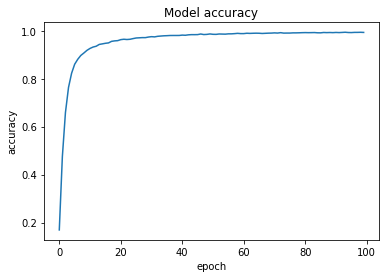

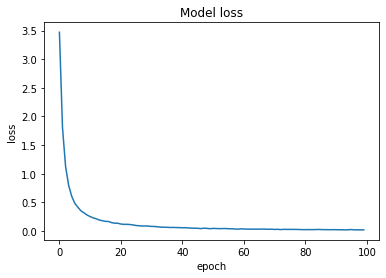

In [32]:
plt.plot(H.history['accuracy'])
#plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
#plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
print(test_loss)

0.3211451161031876
